# Unscented Kalman Filter: Highway Analysis

This Jupyter notebook will analyse the Unscented Kalman Filter (UKF) computations of a single test run.

To capture a test run of the highway scene, start the simulation by writing the terminal output to a CVS file:

`$ ukf_highway.exe >ukf_log.csv`

### Read log file

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("ukf_log.csv", skiprows=0);
df.describe()

,t,dt,lidar_x,lidar_y,nis_lidar,radar_r,radar_phi,radar_dr,nis_radar,x_px,x_py,x_v,x_yaw_angle,x_yaw_rate
count,1797.000000,1797.000000,897.000000,897.000000,897.000000,900.000000,900.000000,900.000000,900.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,4.991653,0.016639,11.061983,0.083825,2.282410,15.099658,0.169115,1.048436,3.673922,11.036576,0.075096,2.521891,0.001802,-0.002243
std,2.882750,0.016671,14.974430,3.242351,2.440450,11.340907,1.429066,4.638671,3.212101,14.995145,3.233557,4.936249,0.175574,0.178060
min,0.000000,0.000000,-11.990600,-4.397130,0.000955,3.383320,-2.526510,-6.583270,0.064318,-11.973300,-4.235320,-6.280250,-0.703862,-0.620030
25%,2.500000,0.000000,-1.920760,-3.901720,0.582938,6.175270,-0.358653,-3.055137,1.494028,-1.978910,-3.965450,-1.379200,-0.032500,-0.042319
50%,5.000000,0.000000,9.720430,0.098408,1.463280,11.254500,0.017045,0.847476,2.962255,9.612190,0.040868,4.757680,-0.002911,-0.001179
75%,7.500000,0.033333,20.877100,3.671110,3.130060,21.046600,0.400764,5.405112,4.821915,20.879400,3.668710,5.967370,0.026621,0.034726
max,9.966670,0.033334,50.283900,4.359700,18.465100,50.633800,3.210160,10.337200,37.875700,50.501700,4.099750,10.261400,0.499416,0.776645


In [46]:
df.head(4)

,name,t,dt,sensor_type,lidar_x,lidar_y,nis_lidar,radar_r,radar_phi,radar_dr,nis_radar,x_px,x_py,x_v,x_yaw_angle,x_yaw_rate
0,car1,0.000000,0.000000,radar,NaN,NaN,NaN,10.8145,2.725080,-4.31948,5.26377,-9.81409,3.897790,4.579260,0.000000,0.000000
1,car2,0.000000,0.000000,radar,NaN,NaN,NaN,25.3192,-0.190092,-5.61145,4.21659,24.86540,-4.235320,-5.633500,0.000000,0.000000
2,car3,0.000000,0.000000,radar,NaN,NaN,NaN,12.1654,3.111410,-0.68800,1.66225,-11.96950,-0.209401,0.681292,0.000000,0.000000
3,car1,0.033333,0.033333,lidar,-9.72393,4.02544,0.343165,NaN,NaN,NaN,NaN,-9.71504,3.966160,4.577850,0.194189,0.006701


## Trace Plot

The following figure shows the trace of the lidar measurements (circles) vs. the prediction (line) for each named instance.

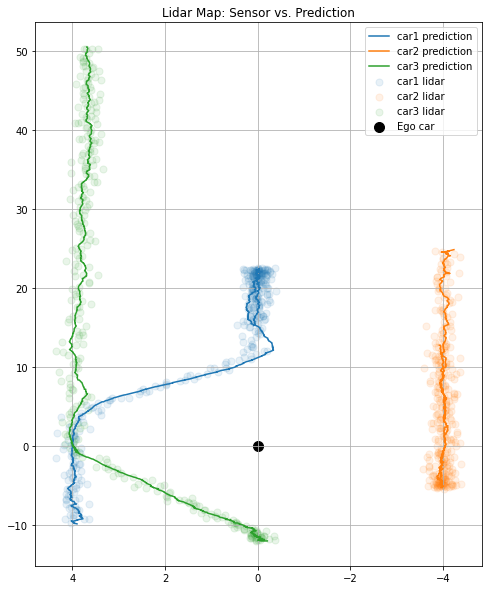

In [47]:
plt.figure(figsize=(8,10))
plt.title("Lidar Map: Sensor vs. Prediction")
for i, name in enumerate(np.unique(df.name)):
    df_i = df[df.name == name]
    c = plt.cm.tab10(i)
    plt.scatter(df_i.lidar_y, df_i.lidar_x, marker="o", s=50, color=c, alpha=0.1, label=f"{name} lidar")
    plt.plot(df_i.x_py, df_i.x_px, color=c, label=f"{name} prediction")    
plt.scatter([0],[0], marker="o", color="black", s=100, label="Ego car")
plt.gca().invert_xaxis()
plt.legend()
plt.grid()
plt.show();

<img src="https://video.udacity-data.com/topher/2019/April/5cb8ef7d_ukf-highway-projected/ukf-highway-projected.gif" width=500 />

## Velocity Profiles

The following figure shown the corresponding speed profile of the 3 cars. Note: Speed is measured relative to the motion of the ego car.

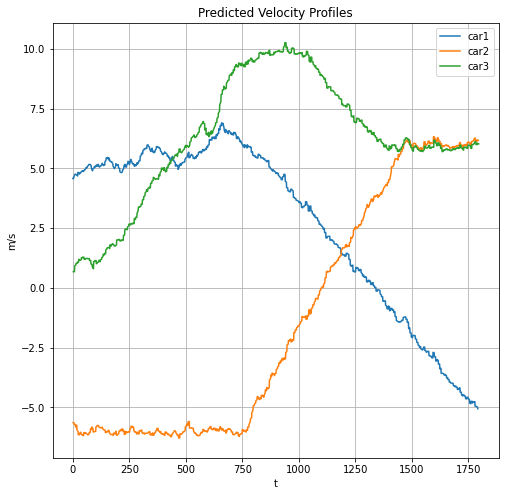

In [48]:
plt.figure(figsize=(8,8))
plt.title("Predicted Velocity Profiles")
for name in np.unique(df.name):
    plt.plot(df[df.name==name].x_v, label=name)
plt.xlabel("t")
plt.ylabel("m/s")
plt.grid()
plt.legend()
plt.show()

## Modelled Process Noise

Next we check the consistency of the selected process noise parameters.

The *Normalized Innovation Squared (NIS)* has been computed for the lidar and radar measurement, as introduced in the lesson [Parameters and Consistency](https://classroom.udacity.com/nanodegrees/nd313/parts/da5e72fc-972d-42ae-bb76-fca3d3b2db06/modules/a247c8c2-7d8c-4298-a3d9-a5eee48805cc/lessons/daf3dee8-7117-48e8-a27a-fc4769d2b954/concepts/f3ba9445-452d-4727-8209-b317d44ff1f1). It relates the difference between prediction and measurement $\Delta_{z}$ to the selected covariance matrix $S$ of the process noise.

NIS value $\epsilon = \Delta_{z}^T \cdot S^{-1} \cdot \Delta_{z}$ follows a $\chi^2$ distribution. To make sure that 95% of the time the prediction doesn't exceeds the expected process variance the NIS should be below the threshold of 6 (2D lidar measurements) or 7.82 (3D radar measurements) respectively.

This is checked in the following figures. Beside some spikes the NIS does not exceed the threshold, which means the deviation in the measurements doesn't exceed the modelled noise.

In [49]:
def plot_nis(series, name="radar", threshold=7.815):
    
    plt.figure(figsize=(12,6))
    title = f"$NIS_{{{name}}}(t)$"
    plt.title(title)
    plt.plot(series)
    plt.hlines(threshold, xmin=0, xmax=len(df), color="red")
    plt.xlabel("t")
    plt.ylabel("NIS")
    plt.grid()
    plt.show()

    plt.title(f"Histogram of $NIS_{{{name}}} values$")
    n,_,_ = plt.hist(series, cumulative=False, bins=30)
    plt.vlines(threshold, ymin=0, ymax=max(n), color="red")
    plt.xlabel("NIS value")
    plt.show()

### Radar

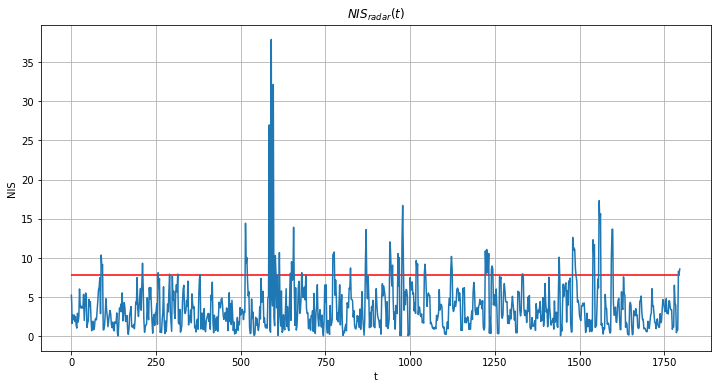

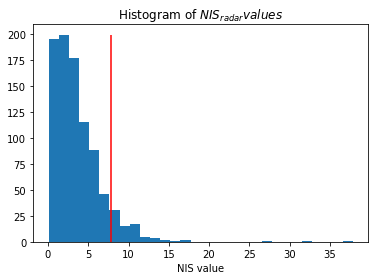

In [50]:
plot_nis(df[df.sensor_type=="radar"].nis_radar, "radar", 7.815)

### Lidar

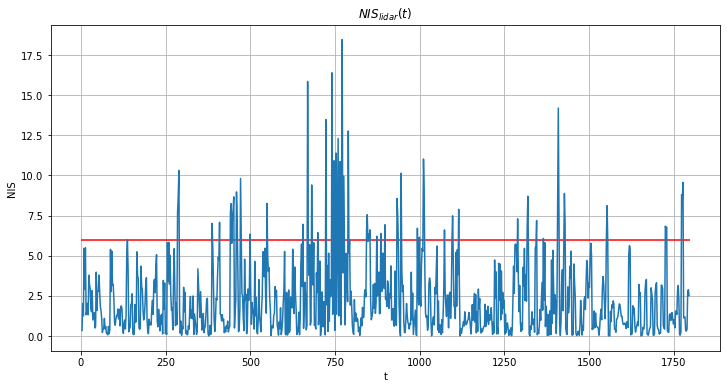

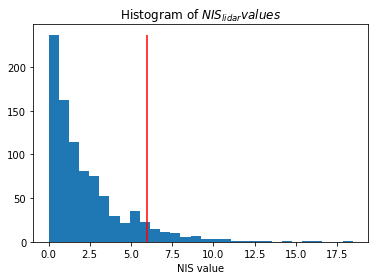

In [51]:
plot_nis(df[df.sensor_type=="lidar"].nis_lidar, "lidar", 6)